In [1]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# TODO: Replace <FILL IN> with appropriate code

from tensorflow.examples.tutorials.mnist import input_data as mnist_data

mnist = mnist_data.read_data_sets("./Datasets/MNIST/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./Datasets/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./Datasets/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./Datasets/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./Datasets/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as offi

In [2]:
# TODO: Replace <FILL IN> with appropriate code

# · · · · · · · · · ·    (input data, 1-deep)                 X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @ -- conv. layer 6x6x1=>6 stride 1        W1 [5, 5, 1, 6]        B1 [6]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                         Y1_hat [batch, 28, 28, 6]
#   @ @ @ @ @ @ @ @   -- conv. layer 5x5x6=>12 stride 2       W2 [5, 5, 6, 12]        B2 [12]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                           Y2_hat [batch, 14, 14, 12]
#     @ @ @ @ @ @     -- conv. layer 4x4x12=>24 stride 2      W3 [4, 4, 12, 24]       B3 [24]
#     ∶∶∶∶∶∶∶∶∶∶∶                                             Y3_hat [batch, 7, 7, 24] => reshaped to YY [batch, 7*7*24]
#      \x/x\x\x/ ✞    -- fully connected layer (relu+dropout) W4 [7*7*24, 200]       B4 [200]
#       · · · ·                                               Y4_hat [batch, 200]
#       \x/x\x/       -- fully connected layer (softmax)      W5 [200, 10]           B5 [10]
#        · · ·                                                Y_hat [batch, 10]

# 

# to reset the Tensorflow default graph
reset_graph()

X = tf.placeholder(tf.float32, [None, 28, 28, 1], name="input")
Y = tf.placeholder(tf.float32, shape=(None, 10), name="labels")
lr = tf.placeholder(tf.float32, shape=[])
pkeep = tf.placeholder(tf.float32, shape=[])

bias_initializer= tf.constant_initializer(value=0.1)

# Convolutional Layers
conv1 = tf.layers.conv2d(
    inputs=X,
    filters=6,
    kernel_size=[5, 5],
    strides=1,
    padding="same",
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.truncated_normal(mean=0, stddev= 0.1),
    bias_initializer=tf.constant_initializer(0.1))

conv2 = tf.layers.conv2d(
    inputs=conv1,
    filters=12,
    kernel_size=[5, 5],
    strides=2,  
    padding="same",
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.truncated_normal(mean=0, stddev= 0.1),
    bias_initializer=tf.constant_initializer(0.1))

conv3 = tf.layers.conv2d(
    inputs=conv2,
    filters=24,
    kernel_size=[4, 4],
    strides=2,  
    padding="same",
    activation=tf.nn.relu,
    kernel_initializer=tf.initializers.truncated_normal(mean=0, stddev= 0.1),
    bias_initializer=tf.constant_initializer(0.1))

# Dense Layers

flattened = tf.reshape(conv3, [-1, 7 * 7 * 24])
dense_1 = tf.layers.dense(inputs=flattened, 
                          units=200, 
                          activation=tf.nn.relu, 
                          kernel_initializer=tf.initializers.truncated_normal(mean=0, stddev= 0.1),
                          bias_initializer=tf.constant_initializer(0.1))

dropout = tf.layers.dropout(inputs=dense_1, rate=0.75)

output = tf.layers.dense(inputs=dropout, 
                         units=10,
                         kernel_initializer=tf.initializers.truncated_normal(mean=0, stddev= 0.1),
                         bias_initializer=tf.constant_initializer(0.1))

########################################
# define the Loss function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=Y, name='cross_entropy_loss')
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# traini the model
########################################
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_step = optimizer.minimize(cross_entropy)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

n_epochs = 2000

max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 800.0

predictions = tf.equal(tf.argmax(output, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(predictions, tf.float32))

X_train_temp, Y_train = mnist.train.images, mnist.train.labels
X_train = np.reshape(X_train_temp, (-1, 28, 28, 1))

X_test_temp, Y_test = mnist.test.images, mnist.test.labels
X_test = np.reshape(X_test_temp, (-1, 28, 28, 1))
    
# checks if learning rate has reached its minimum value
flag = False

new_learning_rate = max_learning_rate

train_losses = []
test_accuracies = []

with tf.Session() as sess:

    sess.run(init)

    for i in range(n_epochs):

        X_batch_temp, Y_batch = mnist.train.next_batch(100)
        X_batch = np.reshape(X_batch_temp, (-1, 28, 28, 1))

        if not flag:
            new_learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * np.exp(-i / decay_speed)
            if new_learning_rate < min_learning_rate:
                flag = True
                new_learning_rate = min_learning_rate

        sess.run(train_step, feed_dict={X: X_batch, Y: Y_batch, lr: new_learning_rate})

        if i % 80 == 0:
            train_loss = sess.run(cross_entropy, feed_dict={X: X_train, Y: Y_train, lr: new_learning_rate})
            print(f'Train set loss for update step {i}: {train_loss}')
            train_losses.append(train_loss)
            test_accuracy = sess.run(accuracy, feed_dict={X: X_test, Y: Y_test, lr: new_learning_rate})
            print(f'Test set accuracy for update step {i}:  {round(test_accuracy*100, 2)}%')
            test_accuracies.append(test_accuracy)

    test_set_accuracy = sess.run(accuracy, feed_dict={X: X_test, Y: Y_test, lr: new_learning_rate})

    print('--------------------------------')
    print()
    print(f'Final test set accuracy: {round(test_set_accuracy*100, 2)}%') 

    print('####################################################################')
    print()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Train set loss for update step 0: 261.7163391113281
Test set accuracy for update step 0:  8.92%
Train set loss for update step 80: 18.675098419189453
Test set accuracy for update step 80:  94.6%
Train set loss for update step 160: 12.64649486541748
Test set accuracy for update step 160:  96.11%
Train set loss for update step 240: 8.43950366973877
Test set accuracy for update step 240:  97.42%
Train set loss for update step 320: 7.385142803192139
Test set accuracy for update step 320:  97.74%
Train set loss for update step 400: 5.455324649810791
Test set accuracy for update step 400:  98.27%
Train set loss for update step 480: 5.185851097106934
Test set accuracy for update step 480:  98.37%
Train set loss for update step 560: 4.813674449920654
Test set accuracy for update step 560:  98.16%
Train set

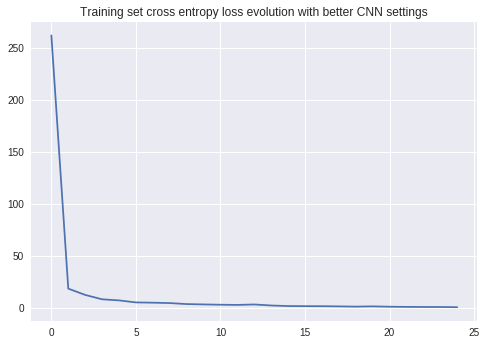

In [3]:
plt.title('Training set cross entropy loss evolution with better CNN settings')
plt.plot(train_losses)

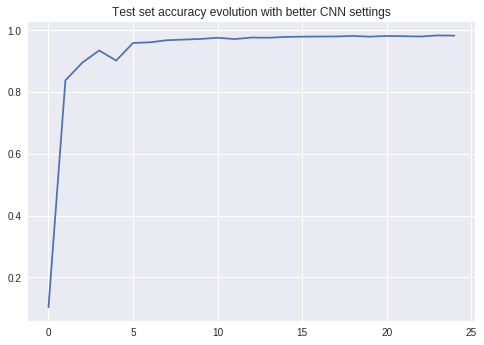

In [0]:
plt.title('Test set accuracy evolution with better CNN settings')
plt.plot(test_accuracies)